In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2 as cv

## Gathering x and y Data from hdf5

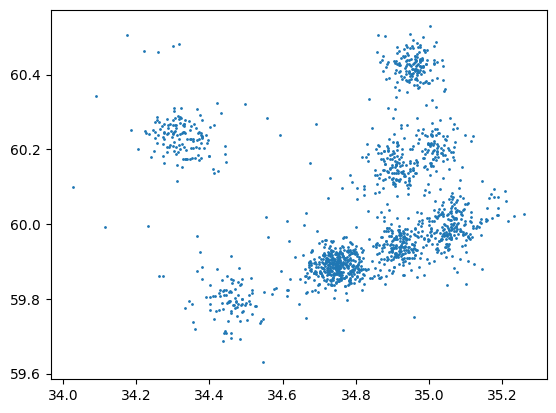

In [2]:
def collect_data(filename):
    
    # Open the file
    with h5py.File(filename, 'r') as f:
        # locs
        locs = f['locs']
        
        x_values = locs['x'][:]
        y_values = locs['y'][:]
        
    data = {
        'x': x_values,
        'y': y_values,
    }
    
    return pd.DataFrame(data)



#testing
data = collect_data('data/indivual_origami_test_set.hdf5')

#plotting
plt.scatter(data['x'], data['y'], s=1)
plt.show()



## Using Kmeans clustering function

[3 3 3 ... 6 6 6]


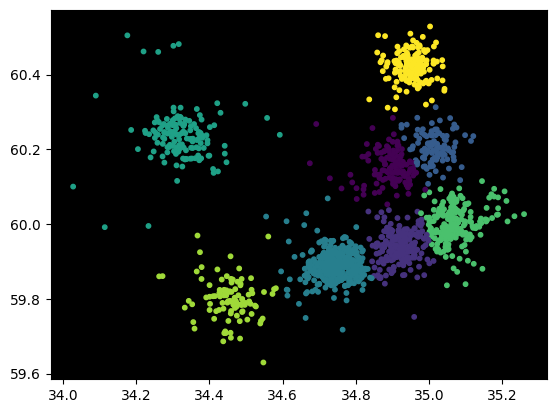

In [3]:
def find_clusters_k_means(data, k):
    kmeans = KMeans(n_clusters=k, random_state = 42 , init= 'k-means++')
    kmeans.fit(data)
    return kmeans.labels_

#testing
labels = find_clusters_k_means(data, 8)
print(labels)

#plotting
plt.axes().set_facecolor('black')
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10)
plt.show()



# Finding the center of mass for each cluster

[(np.float32(34.89331), np.float32(60.15087)), (np.float32(34.920235), np.float32(59.94013)), (np.float32(35.01437), np.float32(60.205975)), (np.float32(34.743652), np.float32(59.889107)), (np.float32(34.321377), np.float32(60.237385)), (np.float32(35.071686), np.float32(59.996765)), (np.float32(34.456066), np.float32(59.7989)), (np.float32(34.95439), np.float32(60.42104))]


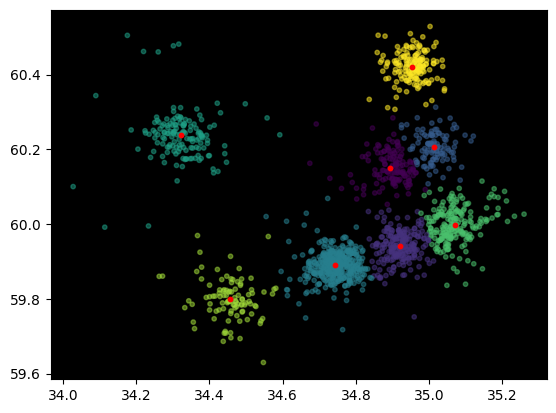

[[34.89331  60.15087 ]
 [34.920235 59.94013 ]
 [35.01437  60.205975]
 [34.743652 59.889107]
 [34.321377 60.237385]
 [35.071686 59.996765]
 [34.456066 59.7989  ]
 [34.95439  60.42104 ]]


In [4]:
def find_com(data, labels):
    com = []
    for i in range(max(labels)+1):
        x = np.mean(data['x'][labels == i])
        y = np.mean(data['y'][labels == i])
        com.append((x, y))
    return com

#testing
com = find_com(data, labels)

print(com)

#plotting
#background color is black
plt.axes().set_facecolor('black')
plt.scatter(data['x'], data['y'], c=labels, cmap='viridis', s=10, alpha=0.5)
com = np.array(com)
plt.scatter(com[:, 0], com[:, 1], c='red', s=10)
plt.show()

print(com)

## Finding the minimum bounding rectangle for the com

/tmp/ipykernel_95720/1807062350.py:60: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))


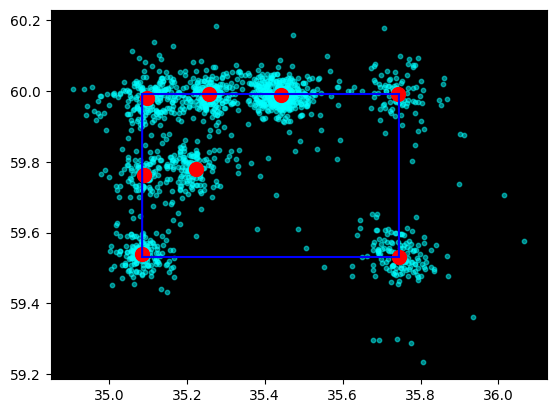

New COM points after rotation:
[[35.22249408 59.78093941]
 [35.25808044 59.99039373]
 [35.09063709 59.76346113]
 [35.44186787 59.98780503]
 [35.74447813 59.53168963]
 [35.09670143 59.98029498]
 [35.74325846 59.99039227]
 [35.08541562 59.54025022]]


In [5]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.
    """
    pi2 = np.pi / 2

    # Get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # Calculate edge angles
    edges = hull_points[1:] - hull_points[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # Find rotation matrices
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles - pi2),
        np.cos(angles + pi2),
        np.cos(angles)
    ]).T
    rotations = rotations.reshape((-1, 2, 2))

    # Apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # Find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # Find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # Return the best box
    x1, x2 = max_x[best_idx], min_x[best_idx]
    y1, y2 = max_y[best_idx], min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

def distance_to_line(point, line_start, line_end):
    """Calculate the perpendicular distance from a point to a line."""
    if np.all(line_start == line_end):
        return np.linalg.norm(point - line_start)
    return np.abs(np.cross(line_end - line_start, point - line_start) / np.linalg.norm(line_end - line_start))

def find_closest_side(points, rectangle):
    """Find the side of the rectangle with the most points closest to it."""
    distances = np.zeros((4, len(points)))
    for i in range(4):
        line_start, line_end = rectangle[i], rectangle[(i + 1) % 4]
        for j, point in enumerate(points):
            distances[i, j] = distance_to_line(point, line_start, line_end)
    min_distances = np.argmin(distances, axis=0)
    closest_side = np.bincount(min_distances).argmax()
    return closest_side

def find_rotation_angle(rectangle, closest_side):
    """
    Find the rotation angle to make the closest side the top side.
    """
    rotation_angle = -np.arctan2(
        rectangle[(closest_side + 1) % 4, 1] - rectangle[closest_side, 1],
        rectangle[(closest_side + 1) % 4, 0] - rectangle[closest_side, 0]
    )
    return rotation_angle

def rotate_points(points, rotation_angle, pivot):
    """
    Rotate the given points around the pivot by the given rotation angle.
    """
    rotation_matrix = np.array([
        [np.cos(rotation_angle), -np.sin(rotation_angle)],
        [np.sin(rotation_angle), np.cos(rotation_angle)]
    ])
    rotated_points = np.dot(points - pivot, rotation_matrix.T) + pivot
    return rotated_points


min_bounding_rect = minimum_bounding_rectangle(com)
closest_side = find_closest_side(com, min_bounding_rect)
rotation_angle = find_rotation_angle(min_bounding_rect, closest_side)

# Rotate data and COM points
rotated_data = rotate_points(data, rotation_angle, min_bounding_rect[closest_side])
rotated_com = rotate_points(com, rotation_angle, min_bounding_rect[closest_side])
rotated_rect = rotate_points(min_bounding_rect, rotation_angle, min_bounding_rect[closest_side])

# Plotting the result
plt.axes().set_facecolor('black')
plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='red', s=100)
for i in range(4):
    plt.plot([rotated_rect[i, 0], rotated_rect[(i + 1) % 4, 0]], 
             [rotated_rect[i, 1], rotated_rect[(i + 1) % 4, 1]], 'b-')

plt.show()

# New COM points after rotation
print("New COM points after rotation:")
print(rotated_com)


In [6]:
def find_middle_left_most_com(rotated_com):
    # sort each com the rotated_com based on its x value
    sorted_com = rotated_com[rotated_com[:, 0].argsort()][:3]
    # print(sorted_com)

    # find the second_highest y value in sorted_com
    for com in sorted_com:
        if com[1] != max(sorted_com[:, 1]) and com[1] != min(sorted_com[:, 1]):
            second_highest_com = com
            break
    return second_highest_com

def find_right_most_com(rotated_com):
    return rotated_com[rotated_com[:, 0].argsort()][-1]

def second_right_most_com(rotated_com):
    return rotated_com[rotated_com[:, 0].argsort()][-2]

In [7]:
second_highest_com = find_middle_left_most_com(rotated_com)
right_most_com = find_right_most_com(rotated_com)
second_right_most_com = second_right_most_com(rotated_com)

In [8]:
def find_robot(rotated_com):
    # find the com closest to the center of the bounded rectangle
    center_x = ((right_most_com[0] - second_highest_com[0]) / 2) + second_highest_com[0]
    center_y = ((right_most_com[1] - second_right_most_com[1]) / 2) + second_right_most_com[1] 
    
    distances = np.sqrt((rotated_com[:, 0] - center_x) ** 2 + (rotated_com[:, 1] - center_y) ** 2)
    closest_com_index = np.argmin(distances)
    closest_com = rotated_com[closest_com_index]
    
    return closest_com

In [9]:
robot = find_robot(rotated_com)

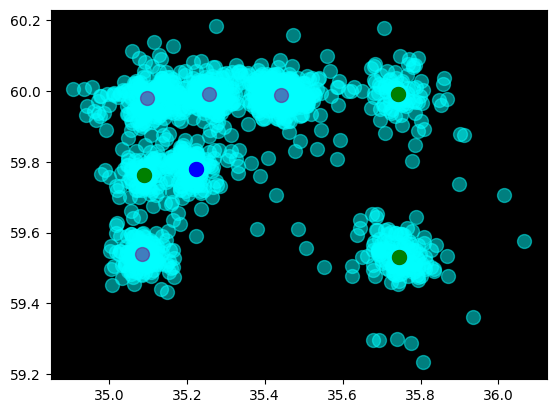

In [10]:
# Plotting second_high_com, right_most_com and second_right_most_com as green points on top of rotated data and rotated com over a scatter plot with cyan points and black background
plt.axes().set_facecolor('black')
plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=100, alpha=0.5)
plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
plt.scatter(robot[0], robot[1], color='blue', s=100)
plt.scatter(second_highest_com[0], second_highest_com[1], color='green', s=100)
plt.scatter(right_most_com[0], right_most_com[1], color='green', s=100)
plt.scatter(second_right_most_com[0], second_right_most_com[1], color='green', s=100)
plt.show()


## Calculate Ratio for Robot Distance

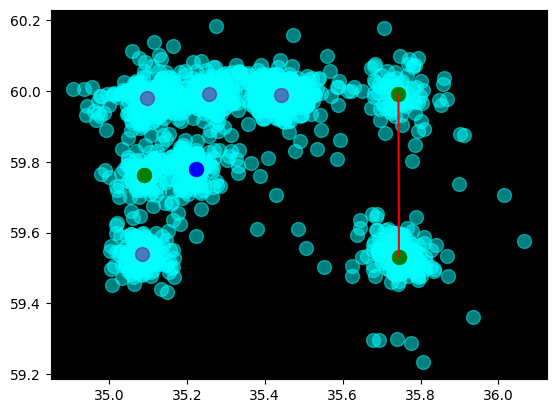

In [11]:
# plot the line between right_most_com and second_right_most_com over the rotated data and rotated com in scatterplot with cyan points and black background 
plt.axes().set_facecolor('black')
plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=100, alpha=0.5)
plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
plt.scatter(robot[0], robot[1], color='blue', s=100)
plt.scatter(second_highest_com[0], second_highest_com[1], color='green', s=100)
plt.scatter(right_most_com[0], right_most_com[1], color='green', s=100)
plt.scatter(second_right_most_com[0], second_right_most_com[1], color='green', s=100)
plt.plot([right_most_com[0], second_right_most_com[0]], [right_most_com[1], second_right_most_com[1]], color='red')
plt.show()

In [16]:
def calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot, right_most_com, second_right_most_com):
    
    def distance_point_to_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        return np.abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1) / np.sqrt((y2-y1)**2 + (x2-x1)**2)

    def intersection_between_point_line(point, line):
        x0, y0 = point
        x1, y1 = line[0]
        x2, y2 = line[1]
        m = (y2-y1) / (x2-x1)
        c = y1 - m*x1
        x = (m*y0 + x0 - m*c) / (m**2 + 1)
        y = m*x + c
        return x, y
    
    # Plotting the 2D scatter plot of the rotated_data with cyan points, rotated_com as green points, and black background
    plt.axes().set_facecolor('black')
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan')
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='green')
    plt.show()
    
    # Show image with rightmost and second rightmost contours
    plt.axes().set_facecolor('black')
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
    plt.scatter(right_most_com[0], right_most_com[1], color='green', s=100)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='green', s=100)
    plt.show()

    # Step 2: Finding the leftmost com
    left_most_com = second_highest_com

    # Show image with leftmost com
    plt.axes().set_facecolor('black')
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
    plt.scatter(left_most_com[0], left_most_com[1], color='green', s=100)
    plt.show()

    # Step 3: Finding the robot com
    robot_com = robot

    # Show image with robot
    plt.axes().set_facecolor('black')
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
    plt.scatter(robot_com[0], robot_com[1], color='green', s=100)

    # Step 4: Define the right line using the centers of the rightmost and second rightmost contours
    right_line = [(right_most_com[0], right_most_com[1]), (second_right_most_com[0], second_right_most_com[1])]

    # Calculate the distance of the left point from the right line
    distance_left_to_right_line = distance_point_to_line(left_most_com, right_line)

    # Calculate the distance of the center of mass point from the right line
    distance_center_of_mass_to_right_line = distance_point_to_line(robot_com, right_line)

    # Step 5: Calculate the exact ratio
    ratio = distance_center_of_mass_to_right_line / distance_left_to_right_line
    
    # Step 6: Getting the intersection points
    intersection_point_x, intersection_point_y = intersection_between_point_line(left_most_com, right_line)
    intersection_point_x_robot_com, intersection_point_y_robot_com = intersection_between_point_line(robot_com, right_line)
    
    # Step 7: Drawing all the robot_com, left_most_com, right_most_com, second_right_most_com, and lines on scatter plot
    plt.axes().set_facecolor('black')
    plt.scatter(rotated_data[:, 0], rotated_data[:, 1], color='cyan', s=10, alpha=0.5)
    plt.scatter(rotated_com[:, 0], rotated_com[:, 1], color='purple', s=100, alpha=0.5)
    plt.scatter(robot_com[0], robot_com[1], color='green', s=100)
    plt.scatter(left_most_com[0], left_most_com[1], color='green', s=100)
    plt.scatter(right_most_com[0], right_most_com[1], color='green', s=100)
    plt.scatter(second_right_most_com[0], second_right_most_com[1], color='green', s=100)
    plt.plot([right_most_com[0], second_right_most_com[0]], [right_most_com[1], second_right_most_com[1]], color='red')
    # draw a line between second_highest_com and (intersection_point_x, intersection_point_y)
    plt.plot([second_highest_com[0], intersection_point_x], [second_highest_com[1], intersection_point_y], color='yellow')
    # draw a line between robot_com and (intersection_point_x_robot_com, intersection_point_y_robot_com)
    plt.plot([robot_com[0], intersection_point_x_robot_com], [robot_com[1], intersection_point_y_robot_com], color='yellow')
    plt.show()
    
    print("Ratio: " + str(ratio))
    
    # # Show and save the final image
    # show_and_save(final_avg_image, 'Final Image with Centers and Lines', 'final_step.png')
    
    # return ratio, distance_left_to_right_line, distance_center_of_mass_to_right_line

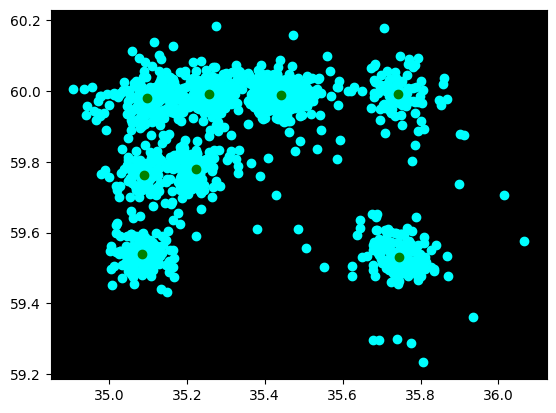

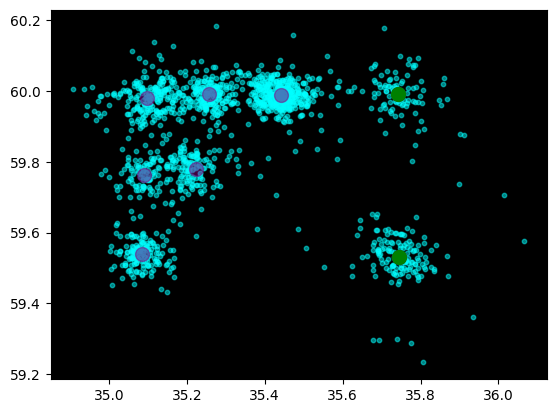

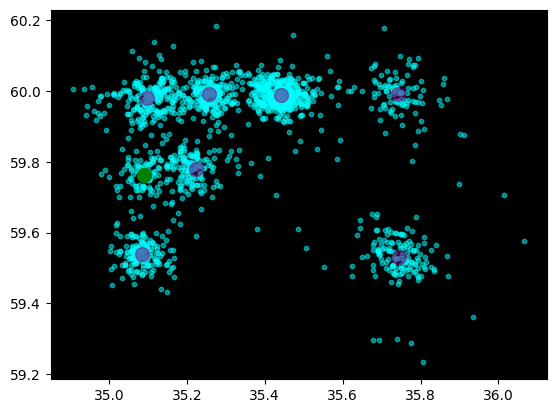

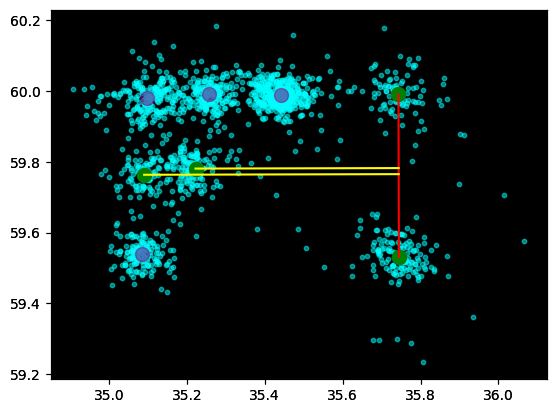

Ratio: 0.7980733866958757


In [17]:
calculate_exact_ratio(rotated_data, rotated_com, second_highest_com, robot, right_most_com, second_right_most_com)